# Ensemble Learning
Ensemble learning is a machine learning paradigm where multiple learners are trained to solve the same problem. In contrast to ordinary machine learning approaches which try to learn one hypothesis from training data, ensemble methods try to construct a set of hypotheses and combine them to use. The main principle is that a group of weak learners come together to form a strong learner, thus increasing the accuracy of the model. When we try to predict the target variable using any machine learning technique, the main causes of difference in actual and predicted values are noise, variance, and bias. Ensemble helps to reduce these factors (except noise, which is irreducible error). We will see 3 different areas meaning, __Bagging__, __Boosting__, __Stacking__ but before we start understanding the algorithms, let's understand what bootstrapping means as it will be helpful to understand the algorithms much better.

## Bootstrapping
In statistics, bootstrapping is any test or metric that relies on random sampling with replacement. Bootstrapping allows assigning measures of accuracy to sample estimates. This technique allows estimation of the sampling distribution of almost any statistic using random sampling methods. Importantly, samples are constructed by drawing observations from a large data sample one at a time and returning them to the data sample after they have been chosen. This allows a given observation to be included in a given small sample more than once. This approach to sampling is called sampling with replacement.

Let's start with importing our libraries


In [1]:
import numpy as np 
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import *
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

['test.csv', 'train.csv']


## About Data
We will be using the Human Activity Recognition with Smartphones data, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The goal is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')

In [3]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [5]:
df_train.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,-0.306043,-0.557121,0.523551,0.387386,0.594374,-0.547569,-0.820041,-0.901874,-0.845784,-0.684345,-0.643770,-0.631069,-0.102993,-0.137937,-0.163946,-0.116599,0.102762,-0.037786,0.130477,-0.026229,0.026322,0.159966,-0.019575,0.009420,0.033291,0.036587,-0.078640,-0.125131,-0.193802,0.105005,...,-0.678618,-0.347657,-0.877995,0.178195,-0.312968,-0.615441,-0.693210,-0.692876,-0.674830,-0.726645,-0.885103,-0.693210,-0.874292,-0.719795,-0.087878,-0.889442,-0.046516,-0.253649,-0.565425,-0.779376,-0.792391,-0.772836,-0.811409,-0.871927,-0.779376,-0.935785,-0.771497,-0.284627,-0.898859,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,0.282243,0.293867,0.363594,0.343611,0.297818,0.471808,0.259607,0.126333,0.221983,0.371608,0.371581,0.386569,0.468959,0.437268,0.371363,0.306507,0.246593,0.243635,0.230067,0.257383,0.215001,0.208837,0.221432,0.

Data has already been scaled. Therefore, no more preprocessing needed except to check for null values and the distrubution of the dataset.

In [6]:
# Check for null values
df_train.isnull().any(axis=None)

False

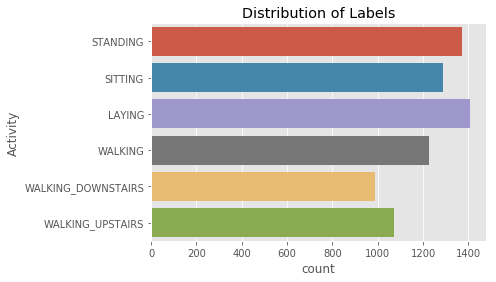

In [7]:
ax = sns.countplot(y=df_train['Activity'])
ax.set_title('Distribution of Labels')
plt.show()

We don't have much of a class imbalanced data so we can perform our algorithms safely. 

## Bagging 
<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1555159889/bagg.png">


Bootstrap Aggregation (or Bagging for short), is a simple and very powerful ensemble method. Bagging is the application of the Bootstrap procedure to a high-variance machine learning algorithm, typically decision trees. When bagging with decision trees, we are less concerned about individual trees overfitting the training data. For this reason and for efficiency, the individual decision trees are grown deep and the trees are not pruned. These trees will have both high variance and low bias. These are important characterize of sub-models when combining predictions using bagging. The only parameters when bagging decision trees is the number of samples and hence the number of trees to include. This can be chosen by increasing the number of trees on run after run until the accuracy begins to stop showing improvement

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1555159889/voting.png">

Since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees. This way we don't have to train the data from scracth all the time. Instead, we just train more trees and add them to our model. Warm start produces errors for baggingclassifier and boosting estimators. So for that situation, we will do it the normal way.   

### Bagging Classifier

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(df_train['Activity'])
df_train['Activity'] = le.transform(df_train['Activity'])
df_test['Activity'] = le.transform(df_test['Activity'])
le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [9]:
X = df_train.drop(['Activity', 'subject'], axis=1)
y = df_train['Activity']

X_test = df_test.drop(['Activity', 'subject'], axis=1)
y_test = df_test['Activity']

In [10]:
from sklearn.ensemble import BaggingClassifier

oob_list = list()
# Because the algorithm is so slow, we use just 4 different trees to see the outcomes.
tree_list = [20, 40, 50, 100] 

for n_trees in tree_list:
    BC = BaggingClassifier(n_estimators=n_trees, oob_score=True, random_state=42, n_jobs=-1)
    BC.fit(X, y)
    oob_error = 1 - BC.oob_score_   # Get the oob error
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

err_bag = pd.concat(oob_list, axis=1).T.set_index('n_trees')

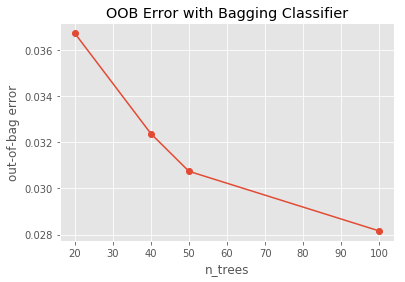

In [11]:
# Plot the result
ax = err_bag.plot(legend=False, marker='o')
ax.set_ylabel('out-of-bag error')
ax.set_title('OOB Error with Bagging Classifier')
plt.show()

In [12]:
# Bagging Classifier with 50 estimators
model = BaggingClassifier(n_estimators=50, oob_score=True, random_state=42, n_jobs=-1)
model = model.fit(X, y)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.88      0.80      0.84       491
           2       0.83      0.90      0.86       532
           3       0.86      0.96      0.91       496
           4       0.93      0.87      0.90       420
           5       0.89      0.83      0.86       471

   micro avg       0.90      0.90      0.90      2947
   macro avg       0.90      0.89      0.90      2947
weighted avg       0.90      0.90      0.90      2947



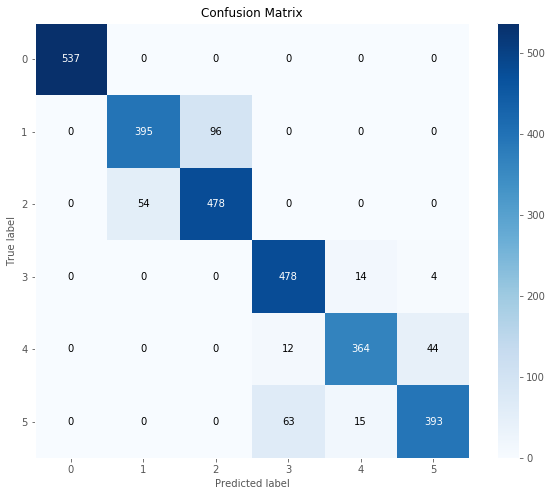

In [14]:
# Plot confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10, 8))
plt.show()

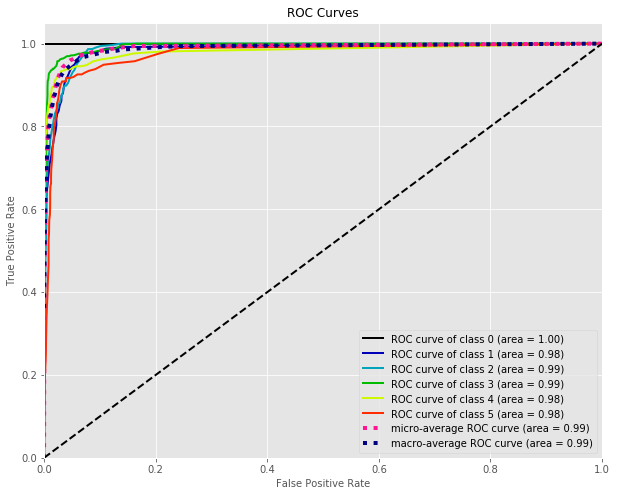

In [17]:
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(10, 8))   # Plot ROC Curve
plt.show()

### Random Forest
The fundamental difference between Bagging and Random Forest is that in Random forests, only a subset of features are selected at random out of the total and the best split feature from the subset is used to split each node in a tree, unlike in bagging where all features are considered for splitting a node.

Bagging has a single parameter, which is the number of trees. All trees are fully grown binary tree (unpruned) and at each node in the tree one searches over all features to find the feature that best splits the data at that node.

Random forests has 2 parameters:
The first parameter is the same as bagging (the number of trees)
The second parameter (unique to randomforests) is mtry which is how many features to search over to find the best feature. this parameter is usually 1/3*D for regression and sqrt(D) for classification. thus during tree creation randomly mtry number of features are chosen from all available features and the best feature that splits the data is chosen.

In [18]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(oob_score=True, random_state=42, warm_start=True, n_jobs=-1)

oob_list = list()
tree_list = [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]

for n_trees in tree_list:
    RF.set_params(n_estimators=n_trees)
    RF.fit(X, y)
    oob_error = 1 - RF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))
    
err_rf = pd.concat(oob_list, axis=1).T.set_index('n_trees')

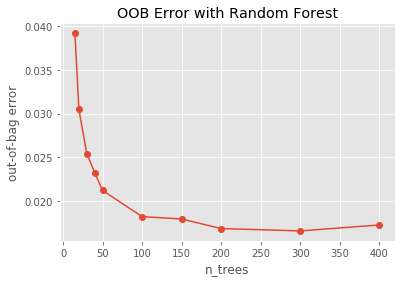

In [19]:
# Plot the result
ax = err_rf.plot(legend=False, marker='o')
ax.set_ylabel('out-of-bag error')
ax.set_title('OOB Error with Random Forest')
plt.show()

In [20]:
# Random Forest with 100 estimators
model = RF.set_params(n_estimators=100)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.91      0.89      0.90       491
           2       0.90      0.92      0.91       532
           3       0.90      0.97      0.94       496
           4       0.96      0.85      0.90       420
           5       0.90      0.92      0.91       471

   micro avg       0.93      0.93      0.93      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.93      0.93      0.93      2947



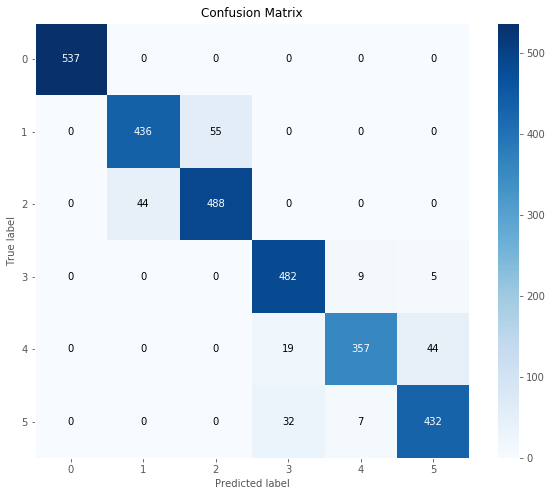

In [21]:
# Plot confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10, 8))
plt.show()

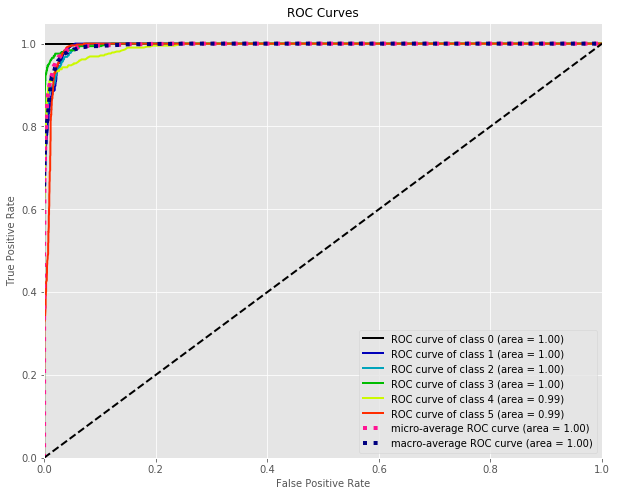

In [22]:
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(10, 8))   # Plot ROC Curve
plt.show()

### Extra Trees Classifier

Sometimes additional randomness is desired beyond Random Forest.Solution is to select features randomly and create splits randomly—don't choose greedily. This is called “Extra Random Trees”

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

ET = ExtraTreesClassifier(oob_score=True, bootstrap=True, random_state=42, warm_start=True, n_jobs=-1)

oob_list = list()
tree_list = [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]

for n_trees in tree_list:
    ET.set_params(n_estimators=n_trees)
    ET.fit(X, y)
    oob_error = 1 - ET.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))
    
err_et = pd.concat(oob_list, axis=1).T.set_index('n_trees')

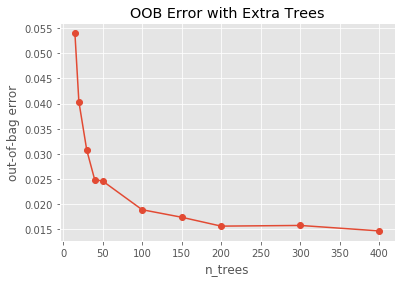

In [25]:
# Plot the result
ax = err_et.plot(legend=False, marker='o')
ax.set_ylabel('out-of-bag error')
ax.set_title('OOB Error with Extra Trees')
plt.show()

In [26]:
# Extra Trees with 100 estimators
model = ET.set_params(n_estimators=100)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.97      0.88      0.92       491
           2       0.90      0.98      0.94       532
           3       0.91      0.97      0.94       496
           4       0.95      0.83      0.89       420
           5       0.90      0.93      0.92       471

   micro avg       0.94      0.94      0.94      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.94      0.94      0.94      2947



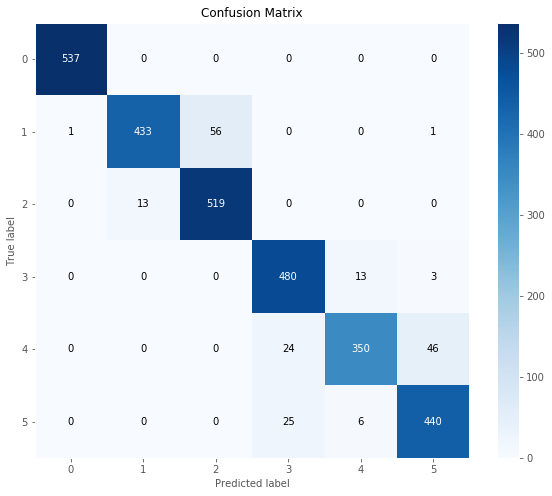

In [27]:
# Plot confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10, 8))
plt.show()

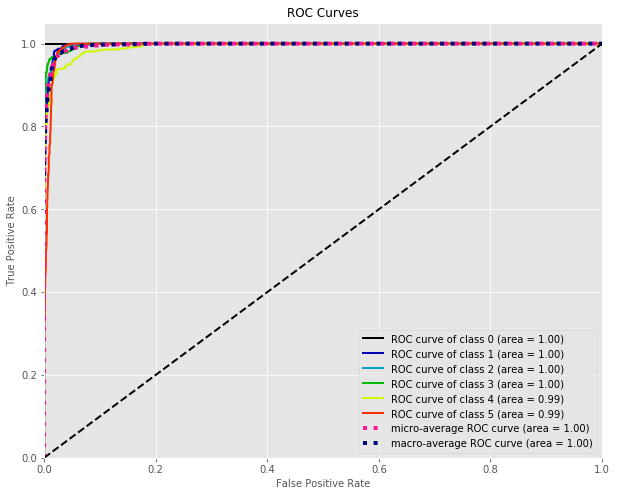

In [28]:
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(10, 8))   # Plot ROC Curve
plt.show()

## Boosting 

<img src='https://res.cloudinary.com/dpyleb8ih/image/upload/v1555167571/boost.png'>

Boosting refers to a group of algorithms that utilize weighted averages to make weak learners into stronger learners. Unlike bagging that had each model run independently and then aggregate the outputs at the end without preference to any model. Boosting is all about “teamwork”. Each model that runs, dictates what features the next model will focus on. Result is weighted sum of all classifiers. Successive classifiers are weighted by learning rate (λ). Using a learning rate < 1.0 helps prevent overfitting (regularization). 

### Bagging vs Boosting

| Bagging  | Boosting |
|---|---|
|Bootstrapped samples   | Fit entire data set  |
|Base trees created independently   | Base trees created successively  |
|Only data points considered   |Use residuals from previous models   |
|No weighting used   |Up-weight misclassified points   |
|Excess trees will not overfit | Beware of overfitting |  
<br>  

Also, there is no such thing as out-of-bag error for boosted models. Boosting utilizes different loss
functions. At each stage, the margin is determined for each point and is positive for correctly
classified points and negative for misclassifications. Value of loss function is calculated
from margin.

<img src='https://res.cloudinary.com/dpyleb8ih/image/upload/v1555168208/loss.png'>

**0-1 Loss Function**
- The 0 – 1 Loss multiplies misclassified points by 1
- Correctly classified points are ignored
- Theoretical "ideal" loss function
- Difficult to optimize non-smooth and non-convex

**AdaBoost Loss Function**
- AdaBoost = Adaptive Boosting
- Loss function is exponential: e (−margin)
- Makes AdaBoost more sensitive to outliers than other types of boosting

**Gradient Boosting Loss Function**
- Generalized boosting method that can use different loss functions
- Common implementation uses binomial log likelihood loss function (deviance): log(1 + e (−margin) )
- More robust to outliers than AdaBoost

**Tuning a Gradient Boosted Model**

- Boosting is additive, so possible to overfit. 
- Use cross validation to set number of trees
- Learning rate (λ): set to <1.0 for regularization. That’s also called “shrinkage”
- Subsample: set to <1.0 to use fraction of data for base learners (stochastic gradient boosting)
- Max_features: number of features to consider in base learners when splitting

And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [15, 50, 100, 200, 400]
for n_trees in tree_list:
    GBC = GradientBoostingClassifier(n_estimators=n_trees, subsample=0.5,
                                     max_features=4, random_state=42)
    GBC.fit(X, y)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

err_gbc = pd.concat(error_list, axis=1).T.set_index('n_trees')

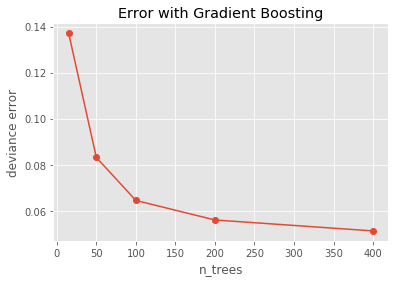

In [33]:
# Plot the result
ax = err_gbc.plot(legend=False, marker='o')
ax.set_ylabel('deviance error')
ax.set_title('Error with Gradient Boosting')
plt.show()

In [34]:
# Extra Trees with 100 estimators
model = GradientBoostingClassifier(n_estimators=100, subsample=0.5,
                                     max_features=4, random_state=42)
model.fit(X, y)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.94      0.88      0.91       491
           2       0.90      0.95      0.92       532
           3       0.91      0.98      0.94       496
           4       0.96      0.86      0.91       420
           5       0.91      0.93      0.92       471

   micro avg       0.94      0.94      0.94      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.94      0.94      0.94      2947



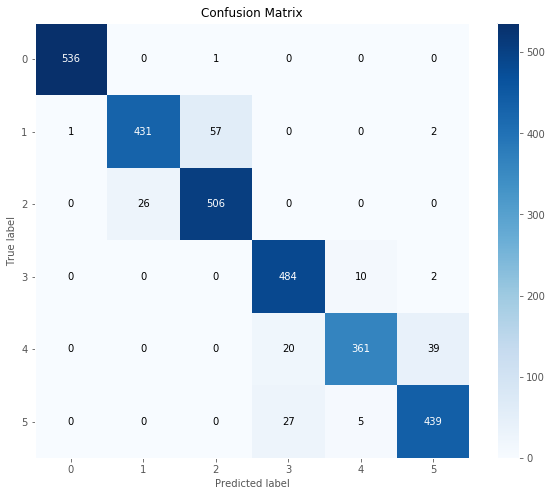

In [35]:
# Plot confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10, 8))
plt.show()

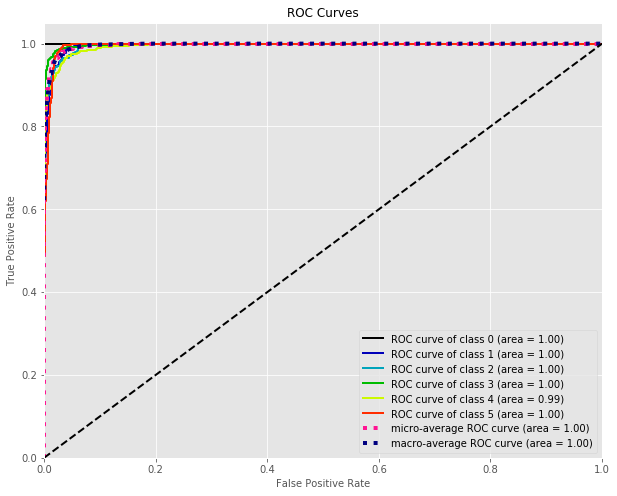

In [36]:
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(10, 8))   # Plot ROC Curve
plt.show()

In [41]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [15, 50, 100, 200, 400]

# Setting max_features=4 in the decision tree classifier used as the base classifier 
# for AdaBoost will increase the convergence rate
base = DecisionTreeClassifier(max_features=4)
for n_trees in tree_list:
    ABC = AdaBoostClassifier(base_estimator=base, n_estimators=n_trees, 
                             learning_rate=0.1, random_state=42)
    ABC.fit(X, y)
    y_pred = ABC.predict(X_test)

    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

err_abc = pd.concat(error_list, axis=1).T.set_index('n_trees')

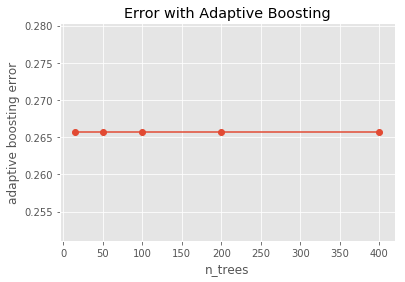

In [42]:
# Plot the result
ax = err_abc.plot(legend=False, marker='o')
ax.set_ylabel('adaptive boosting error')
ax.set_title('Error with Adaptive Boosting')
plt.show()

In [45]:
model = AdaBoostClassifier(base_estimator=base, n_estimators=50, 
                             learning_rate=0.1, random_state=42)
model.fit(X, y)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       537
           1       0.67      0.66      0.67       491
           2       0.77      0.78      0.77       532
           3       0.71      0.81      0.76       496
           4       0.75      0.65      0.70       420
           5       0.68      0.66      0.67       471

   micro avg       0.73      0.73      0.73      2947
   macro avg       0.73      0.73      0.73      2947
weighted avg       0.74      0.73      0.73      2947



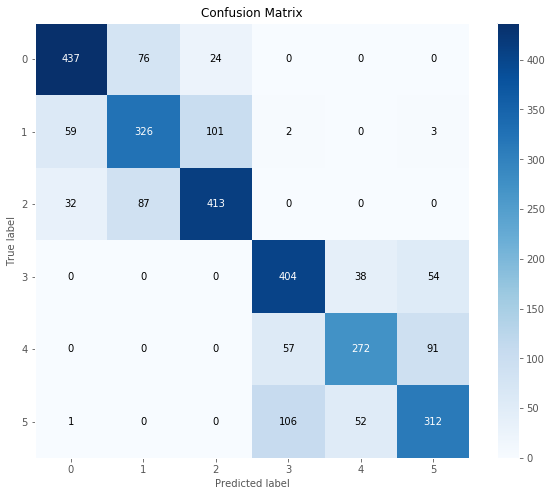

In [46]:
# Plot confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10, 8))
plt.show()

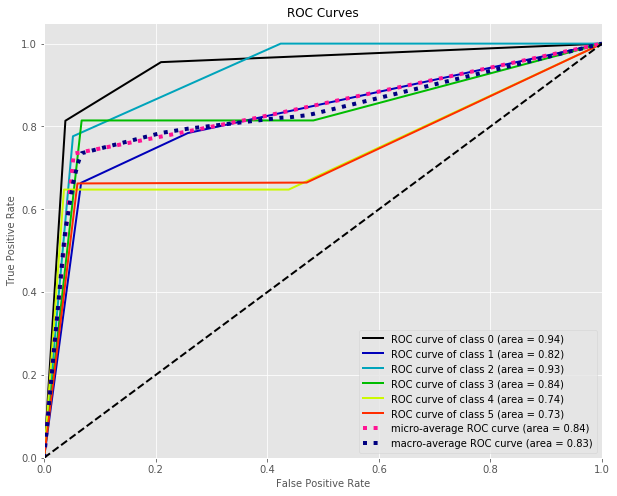

In [47]:
y_probas = model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(10, 8))   # Plot ROC Curve
plt.show()

## Stacking 

<img src='https://res.cloudinary.com/dpyleb8ih/image/upload/v1555167571/stack.png'>

Stacking is another ensemble model, where a new model is trained from the combined predictions of two (or more) previous model. The predictions from the models are used as inputs for each sequential layer, and combined to form a new set of predictions. These can be used on additional layers, or the process can stop here with a final result.

Ensemble stacking can be referred to as blending, because all the numbers are blended to produce a prediction or classification.

- Output of base learners can be combined via majority vote or weighted
- Additional hold-out data needed if meta learner parameters are used
- Be aware of increasing model complexity

In [49]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
LR = LogisticRegressionCV(Cs=5, cv=4, penalty='l2', max_iter=1000)
LR.fit(X, y)

LogisticRegressionCV(Cs=5, class_weight=None, cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [50]:
y_pred = LR.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       539
           1       0.87      0.97      0.92       442
           2       0.97      0.90      0.94       576
           3       0.99      0.96      0.97       512
           4       0.99      0.98      0.98       423
           5       0.96      0.99      0.97       455

   micro avg       0.96      0.96      0.96      2947
   macro avg       0.96      0.97      0.96      2947
weighted avg       0.96      0.96      0.96      2947



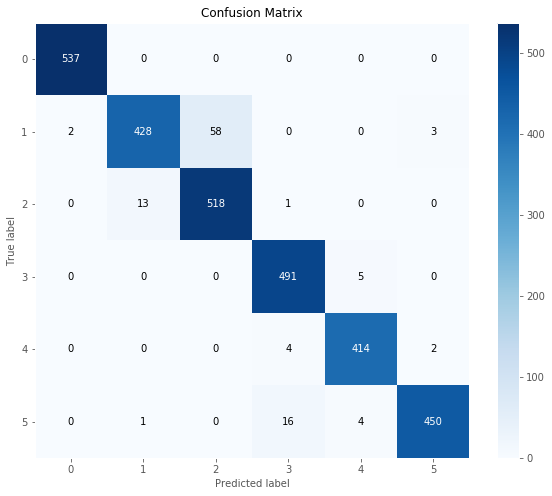

In [51]:
# Plot confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10, 8))
plt.show()

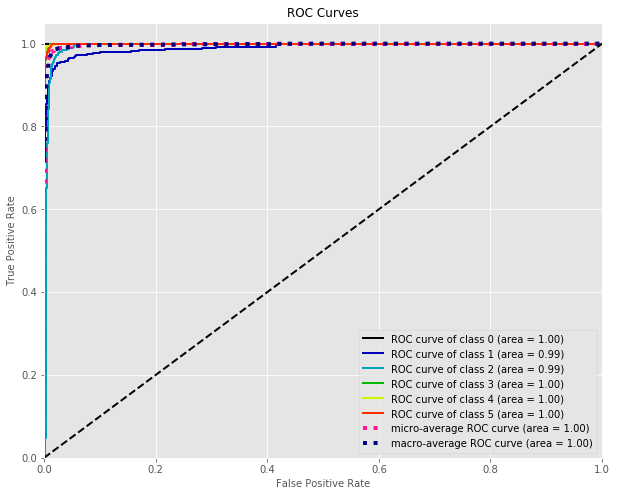

In [52]:
y_probas = LR.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(10, 8))   # Plot ROC Curve
plt.show()

Now, we stack Logistic regression with Gradient Boosting to make a new classifier

In [55]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR', LR), ('GBC', GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft', n_jobs=-1)
VC.fit(X, y)

VotingClassifier(estimators=[('LR', LogisticRegressionCV(Cs=5, class_weight=None, cv=4, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0...    subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [56]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.98      0.89      0.93       491
           2       0.91      0.98      0.95       532
           3       0.97      0.99      0.98       496
           4       0.99      0.98      0.98       420
           5       0.97      0.96      0.97       471

   micro avg       0.97      0.97      0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



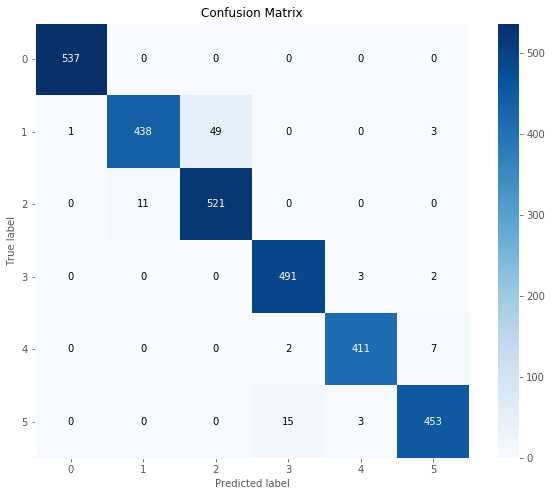

In [57]:
# Plot confusion Matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(10, 8))
plt.show()

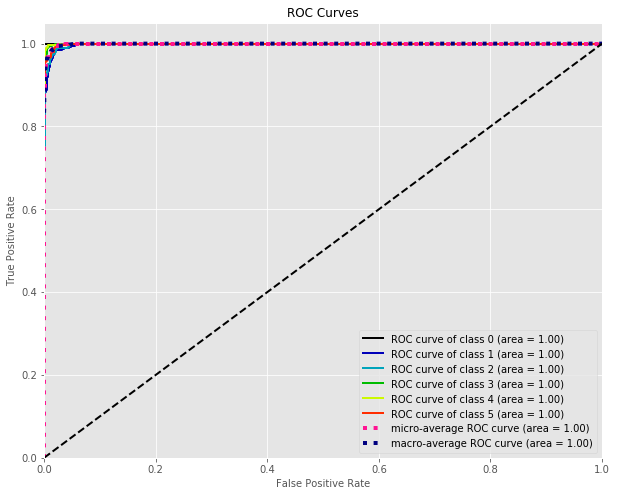

In [58]:
y_probas = VC.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas, figsize=(10, 8))   # Plot ROC Curve
plt.show()

## Conclusions 

Our best model appears to be the stacked model judjin by the confusion matrix and the ROC curve. Also note that, Logistic regression itself performs better than most of the complicated models. So, always start simple and make it complex as you need it.

Don't forget to upvote if you like my kernel :)